In [1]:
import numpy as np
import glob, os
import matplotlib.pyplot as plt

from blg_strain.lattice import StrainedLattice
from blg_strain.bands import BandStructure, FilledBands
from blg_strain.utils.utils import print_time
from blg_strain.utils.saver import Saver

In [14]:
sl = StrainedLattice(eps=0.01, theta=0)
sl.calculate()

In [15]:
bs = BandStructure(sl, Delta=5e-3)
bs.calculate()

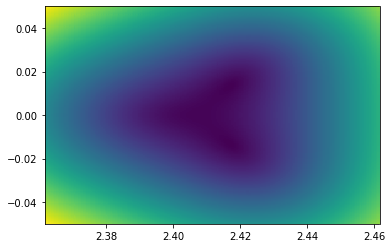

In [16]:
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, bs.E[2])

In [17]:
fb = FilledBands(bs, EF=5e-3)
fb.calculate()

In [18]:
fb.alpha

array([-1.06834693e-06, -3.81235716e-11])

# Contours

1) Calculate fermi distribution

In [276]:
%matplotlib notebook

In [277]:
from blg_strain.microscopic import feq_func

EF = 0.003
T = .1
f = feq_func(bs.E, EF, T)

<IPython.core.display.Javascript object>


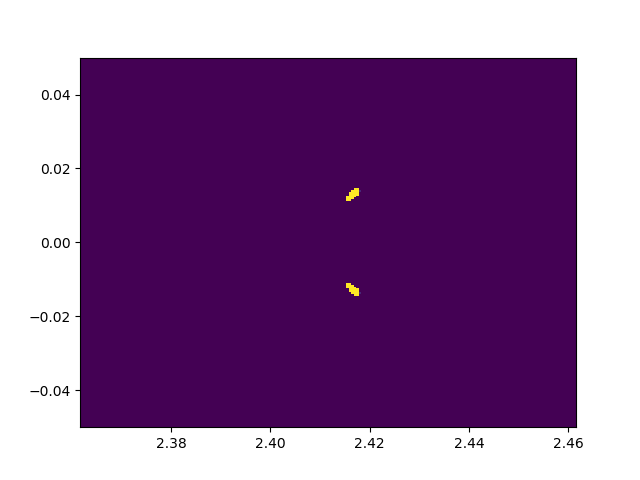

In [278]:
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, f[2])

2) Find the contour E == EF. This corresponds to f == 1/2. We do not want to calculate f first, because we lose information, especially at low temperature where the width of the step transition is smaller than the grid spacing.

In [279]:
from skimage.measure import find_contours

<IPython.core.display.Javascript object>


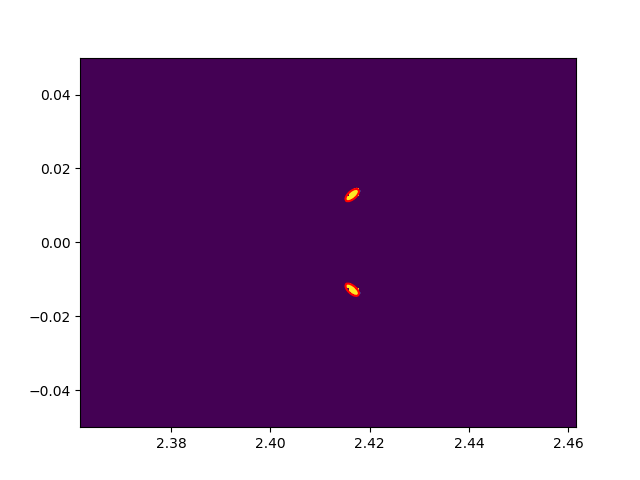

In [280]:
contours = find_contours(bs.E[2], EF)
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, f[2])

scalex, scaley = (bs.Kxa.max()-bs.Kxa.min()) / (bs.Kxa.shape[0]-1), (bs.Kya.max()-bs.Kya.min()) / (bs.Kxa.shape[1]-1),

for c in contours:
    c[:,0] = bs.Kxa.min() + c[:,0] * scalex
    c[:,1] = bs.Kya.min() + c[:,1] * scaley
    ax.plot(c[:,0], c[:,1], color='r')


3) At zero temperature, evaluate integrand along the contour (don't integrate by parts)

In [281]:
from scipy.interpolate import RectBivariateSpline

In [282]:
from blg_strain.utils.const import a0, hbar, q

In [283]:
integrand = 1 / (2 * np.pi  * a0) ** 2 * (bs.Mu + q * bs.Omega / hbar * (EF - bs.E))

In [284]:
integrand.shape

(4, 200, 200)

<IPython.core.display.Javascript object>


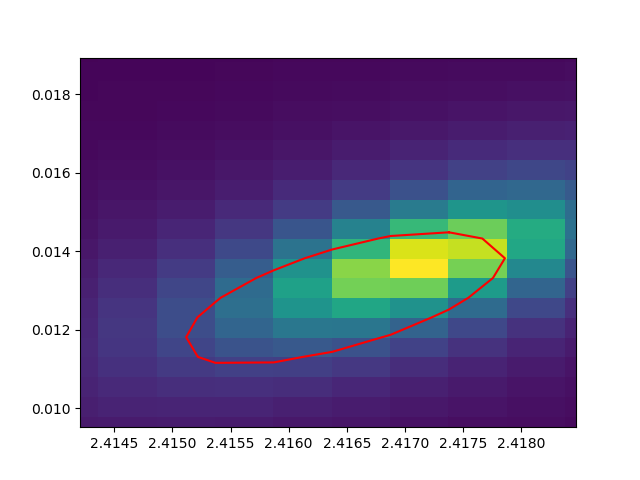

In [285]:
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, integrand[2])
for c in contours:
    ax.plot(c[:,0], c[:,1], color='r')

In [271]:
from scipy.interpolate import interp1d

In [286]:
ss = np.arange(len(c[:,0]))
f1 = interp1d(ss, c[:,0])
f2 = interp1d(ss, c[:,1])
ss2 = np.linspace(ss.min(), ss.max(), 1000)

<IPython.core.display.Javascript object>


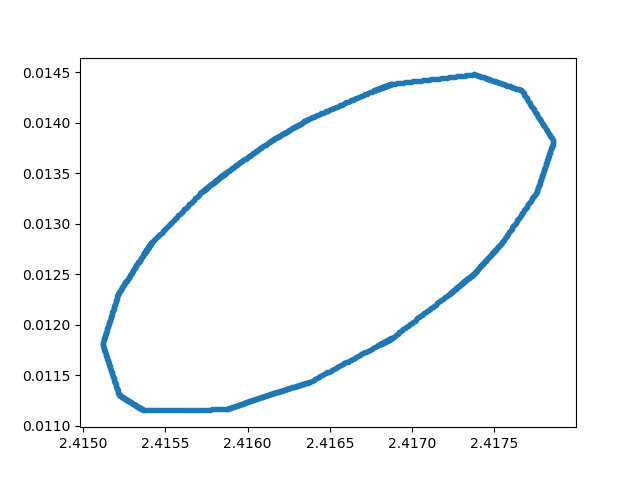

In [287]:
fig, ax = plt.subplots()
ax.plot(f1(ss2), f2(ss2), '.')

In [291]:
spl = RectBivariateSpline(bs.kxa, bs.kya, integrand[2])

In [292]:
kxa = np.linspace(bs.kxa.min(), bs.kxa.max(), 1000)
kya = np.linspace(bs.kya.min(), bs.kya.max(), 1000)

<IPython.core.display.Javascript object>


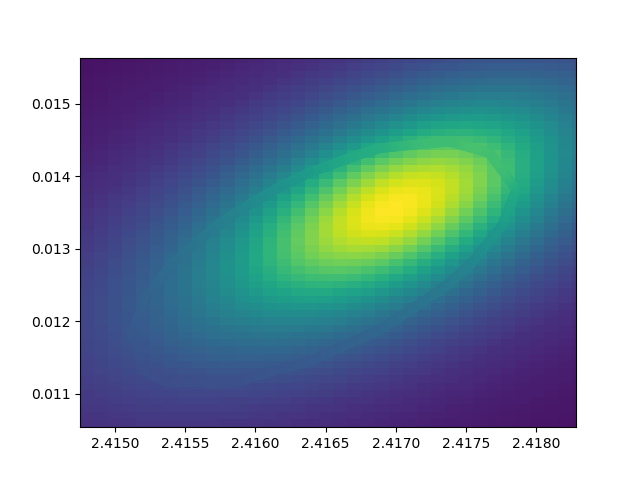

In [295]:
fig, ax = plt.subplots()
C = spl(kxa, kya).T
vmin = C.min()
vmax = C.max()
ax.pcolormesh(kxa, kya, C)
ax.scatter(f1(ss2), f2(ss2), c=spl(f1(ss2), f2(ss2), grid=False), vmin=vmin, vmax=vmax)

In [253]:
spl(f(ss2), f2(ss2), grid=False)

array([-1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
       -1.4329551e-06, -1.4329551e-06, -1.4329551e-06, -1.4329551e-06,
      

In [310]:
spl(kxa, kya).nbytes, kxa.nbytes, kya.nbytes

(8000000, 8000, 8000)

In [300]:
a, b, c = spl.tck

In [311]:
a.nbytes, b.nbytes, c.nbytes

(1632, 1632, 320000)

In [348]:
class MySpline(RectBivariateSpline, Saver):
    def __init__(self):
        pass
    
    def calculate(self, x, y, z):
        super().__init__(x,y,z)
        
    def save(self, filename):
        self.tx, self.ty, self.c = self.tck
        super().save(filename)
        
    @classmethod
    def load(cls, filename):
        obj = super().load(filename)
        obj.tck = obj.tx, obj.ty, obj.c
        return obj

In [349]:
spl = MySpline()
spl.calculate(bs.kxa, bs.kya, integrand[2])

In [353]:
spl.__dict__

{'c': array([-1.59805689e-06, -1.60663075e-06, -1.61953890e-06, ...,
        -1.46183283e-06, -1.44441981e-06, -1.43295510e-06]),
 'degrees': array([3, 3]),
 'fp': 0.0,
 'obj_filenames': array([], dtype=float64),
 'tck': (array([2.36160065, 2.36160065, 2.36160065, 2.36160065, 2.36260568,
         2.36310819, 2.3636107 , 2.36411321, 2.36461573, 2.36511824,
         2.36562075, 2.36612326, 2.36662578, 2.36712829, 2.3676308 ,
         2.36813331, 2.36863583, 2.36913834, 2.36964085, 2.37014336,
         2.37064588, 2.37114839, 2.3716509 , 2.37215341, 2.37265593,
         2.37315844, 2.37366095, 2.37416346, 2.37466598, 2.37516849,
         2.375671  , 2.37617352, 2.37667603, 2.37717854, 2.37768105,
         2.37818357, 2.37868608, 2.37918859, 2.3796911 , 2.38019362,
         2.38069613, 2.38119864, 2.38170115, 2.38220367, 2.38270618,
         2.38320869, 2.3837112 , 2.38421372, 2.38471623, 2.38521874,
         2.38572125, 2.38622377, 2.38672628, 2.38722879, 2.3877313 ,
         2.38823382, 

In [351]:
spl.save('./test.spl')

In [352]:
spl = MySpline.load('./test.spl')

In [347]:
spl(kxa, kya)

array([[-1.59805689e-06, -1.60061968e-06, -1.60318435e-06, ...,
        -1.60318471e-06, -1.60062004e-06, -1.59805724e-06],
       [-1.60122942e-06, -1.60380305e-06, -1.60637857e-06, ...,
        -1.60637893e-06, -1.60380341e-06, -1.60122978e-06],
       [-1.60440584e-06, -1.60699033e-06, -1.60957674e-06, ...,
        -1.60957710e-06, -1.60699069e-06, -1.60440620e-06],
       ...,
       [-1.43838947e-06, -1.44184312e-06, -1.44530541e-06, ...,
        -1.44530589e-06, -1.44184360e-06, -1.43838995e-06],
       [-1.43566824e-06, -1.43911000e-06, -1.44256036e-06, ...,
        -1.44256084e-06, -1.43911048e-06, -1.43566872e-06],
       [-1.43295462e-06, -1.43638455e-06, -1.43982303e-06, ...,
        -1.43982351e-06, -1.43638502e-06, -1.43295510e-06]])

# Now have a spline class

In [29]:
import numpy as np
import glob, os
import matplotlib.pyplot as plt

from blg_strain.lattice import StrainedLattice
from blg_strain.bands import BandStructure, FilledBands
from blg_strain.utils.utils import print_time
from blg_strain.utils.saver import Saver
from blg_strain.utils.utils import Spline
from blg_strain.microscopic import feq_func

from skimage.measure import find_contours
from blg_strain.utils.const import a0, hbar, q

from scipy.interpolate import interp1d

In [19]:
%matplotlib notebook

In [40]:
def get_contours(Kx, Ky, E, EF):
    contours = find_contours(E, EF)
    scalex = (Kx.max() - Kx.min()) / (Kx.shape[0] - 1)
    scaley = (Ky.max() - Ky.min()) / (Ky.shape[1] - 1)
    for c in contours:
        c[:, 0] = Kx.min() + c[:, 0] * scalex
        c[:, 1] = Ky.min() + c[:, 1] * scaley
    return contours

## Calculate band structure

In [20]:
sl = StrainedLattice(eps=0.01, theta=0)
sl.calculate()

In [21]:
bs = BandStructure(sl, Delta=5e-3)
bs.calculate()

In [45]:
EF = 0.004
T = 4.2
f = feq_func(bs.E, EF, T)

## Plot contour on Fermi distribution

This won't work at elevated temperature.. there are parts of the occupation we can't predict from the 0 K Fermi surface

<IPython.core.display.Javascript object>


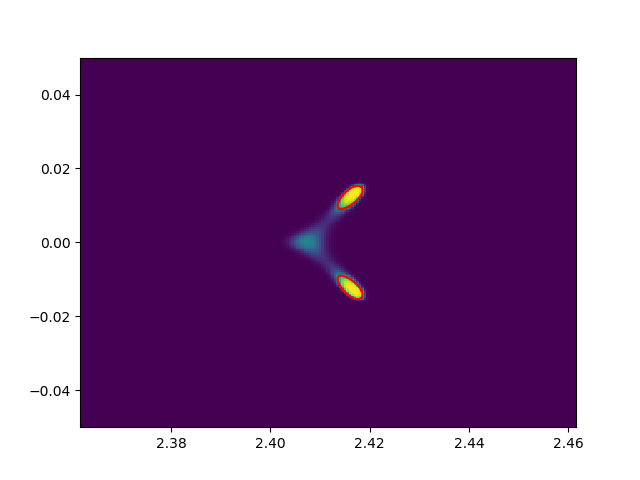

In [46]:
contours = get_contours(bs.Kxa, bs.Kya, bs.E[2], EF)
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, f[2])

for c in contours:
    ax.plot(c[:,0], c[:,1], color='r')

In [25]:
integrand = 1 / (2 * np.pi  * a0) ** 2 * (bs.Mu + q * bs.Omega / hbar * (EF - bs.E))

<IPython.core.display.Javascript object>


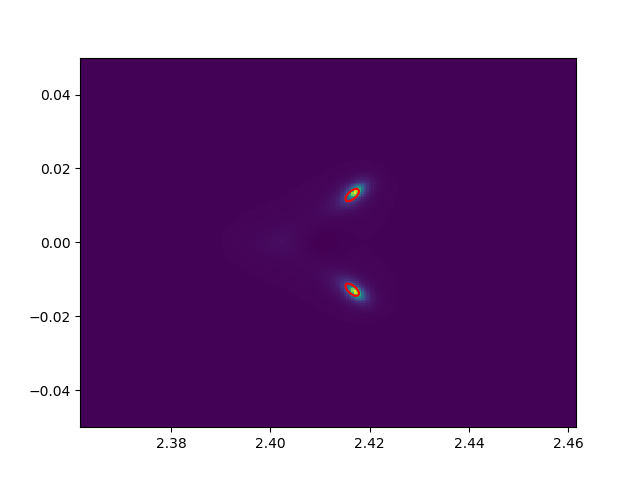

In [42]:
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, integrand[2])
for c in contours:
    ax.plot(c[:,0], c[:,1], color='r')

In [30]:
ss = np.arange(len(c[:,0]))
f1 = interp1d(ss, c[:,0])
f2 = interp1d(ss, c[:,1])
ss2 = np.linspace(ss.min(), ss.max(), 1000)

In [35]:
spl = Spline()
spl.calculate(bs.kxa, bs.kya, integrand[2])

In [36]:
kxa = np.linspace(bs.kxa.min(), bs.kxa.max(), 1000)
kya = np.linspace(bs.kya.min(), bs.kya.max(), 1000)

<IPython.core.display.Javascript object>


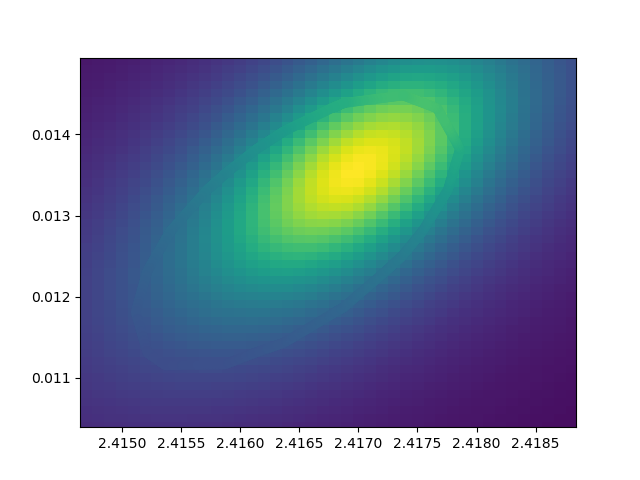

In [37]:
fig, ax = plt.subplots()
C = spl(kxa, kya).T
vmin = C.min()
vmax = C.max()
ax.pcolormesh(kxa, kya, C)
ax.scatter(f1(ss2), f2(ss2), c=spl(f1(ss2), f2(ss2), grid=False), vmin=vmin, vmax=vmax)

# Make sure spline class working fully

In [1]:
import numpy as np
import glob, os
import matplotlib.pyplot as plt

from blg_strain.lattice import StrainedLattice
from blg_strain.bands import BandStructure, FilledBands
from blg_strain.utils.utils import print_time
from blg_strain.utils.saver import Saver
from blg_strain.utils.utils import Spline
from blg_strain.microscopic import feq_func

from skimage.measure import find_contours
from blg_strain.utils.const import a0, hbar, q

from scipy.interpolate import interp1d

In [2]:
%matplotlib notebook

## Calculate band structure

In [3]:
sl = StrainedLattice(eps=0.01, theta=0)
sl.calculate()

In [4]:
bs = BandStructure(sl, Delta=5e-3)
bs.calculate()

In [5]:
EF=0.004
T = 4.2

In [6]:
%%time
fb = FilledBands(bs, EF=EF, T=T)
fb.calculate(1000, 1000) # what takes so long?

Wall time: 542 ms


In [8]:
fb.alpha

array([-1.56307359e-06, -5.01599411e-11])

In [5]:
sl.save('test')

In [6]:
bs.save()

splE
b'\x80\x03cnumpy.core.m'
splPr
b'\x80\x03cnumpy.core.m'
splPi
b'\x80\x03cnumpy.core.m'
splO
b'\x80\x03cnumpy.core.m'
splM
b'\x80\x03cnumpy.core.m'
obj_filenames
b'\x80\x03]q\x00X+\x00\x00\x00test\\'


In [9]:
fb.save()

obj_filenames


In [10]:
bs.__dict__

{'sl': <blg_strain.lattice.StrainedLattice at 0x218ac7eaa48>,
 'window': 0.1,
 'Delta': 0.005,
 'Nkx': 200,
 'Nky': 200,
 'kxa': array([2.36160065, 2.36210316, 2.36260568, 2.36310819, 2.3636107 ,
        2.36411321, 2.36461573, 2.36511824, 2.36562075, 2.36612326,
        2.36662578, 2.36712829, 2.3676308 , 2.36813331, 2.36863583,
        2.36913834, 2.36964085, 2.37014336, 2.37064588, 2.37114839,
        2.3716509 , 2.37215341, 2.37265593, 2.37315844, 2.37366095,
        2.37416346, 2.37466598, 2.37516849, 2.375671  , 2.37617352,
        2.37667603, 2.37717854, 2.37768105, 2.37818357, 2.37868608,
        2.37918859, 2.3796911 , 2.38019362, 2.38069613, 2.38119864,
        2.38170115, 2.38220367, 2.38270618, 2.38320869, 2.3837112 ,
        2.38421372, 2.38471623, 2.38521874, 2.38572125, 2.38622377,
        2.38672628, 2.38722879, 2.3877313 , 2.38823382, 2.38873633,
        2.38923884, 2.38974135, 2.39024387, 2.39074638, 2.39124889,
        2.3917514 , 2.39225392, 2.39275643, 2.39325894, 

In [13]:
fb2 = fb.load(r"C:\Users\Brian\Documents\GitHub\blg_strain\notebooks\test.h5\StrainedLattice_eps0.010_theta0.000\BandStructure_Nkx200_Nky200_Delta5.000\FilledBands_EF4.000_T4.2.h5")

In [14]:
fb2.__dict__

{'bs': <blg_strain.utils.saver.Saver at 0x211900d9808>,
 'EF': 0.004,
 'T': 4.2,
 'D': 26027027.489771917,
 'Nkx_new': 1000,
 'Nky_new': 1000,
 'alpha': array([-1.56307359e-06, -5.01599411e-11]),
 'filename': 'test.h5\\StrainedLattice_eps0.010_theta0.000\\BandStructure_Nkx200_Nky200_Delta5.000\\FilledBands_EF4.000_T4.2.h5',
 'kxa': array([2.36160065, 2.36170075, 2.36180085, 2.36190095, 2.36200105,
        2.36210115, 2.36220125, 2.36230135, 2.36240145, 2.36250155,
        2.36260165, 2.36270175, 2.36280185, 2.36290195, 2.36300205,
        2.36310215, 2.36320225, 2.36330235, 2.36340245, 2.36350255,
        2.36360265, 2.36370275, 2.36380285, 2.36390295, 2.36400305,
        2.36410315, 2.36420325, 2.36430335, 2.36440345, 2.36450355,
        2.36460365, 2.36470375, 2.36480385, 2.36490395, 2.36500405,
        2.36510415, 2.36520425, 2.36530435, 2.36540445, 2.36550455,
        2.36560465, 2.36570475, 2.36580486, 2.36590496, 2.36600506,
        2.36610516, 2.36620526, 2.36630536, 2.36640546,

In [5]:
bs2 = BandStructure.load(r"C:\Users\Brian\Documents\GitHub\blg_strain\notebooks\test\StrainedLattice_eps0.010_theta0.000\BandStructure_Nkx200_Nky200_Delta5.000.h5")

<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.float64'>


In [10]:
bs.splE[0](3,3)

array([[-0.58971925]])

In [10]:
import pickle

In [7]:
pickle.loads(bs2.splE)

NameError: name 'pickle' is not defined

In [11]:
s = pickle.dumps(bs.splE)

In [13]:
splE = pickle.loads(s)

In [14]:
splE[0](2,4)

array([[-0.56356567]])

# Try saving splines to h5

In [9]:
import h5py

In [13]:
bs.splE

array([<blg_strain.utils.utils.Spline object at 0x000001C2DB1D89C8>,
      dtype=object)

In [18]:
import pickle

In [26]:
f = h5py.File('test2.h5', 'w')

splE = pickle.dumps(bs.splE)
f.create_dataset('splE', data=np.array(splE))

<HDF5 dataset "splE": shape (), type "|S1293939">

In [27]:
f.close()

In [29]:
f = h5py.File('test2.h5', 'r')

In [32]:
s = f['splE'][()]

In [33]:
pickle.loads(s)

array([<blg_strain.utils.utils.Spline object at 0x000001C2DFE08588>,
      dtype=object)

In [7]:
Ns = np.array([200, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 5000])
alphas = np.empty_like(Ns, dtype=float)
for i, N in enumerate(Ns):
    fb.calculate(N, N)
    alphas[i] = fb.alpha[0]

<IPython.core.display.Javascript object>


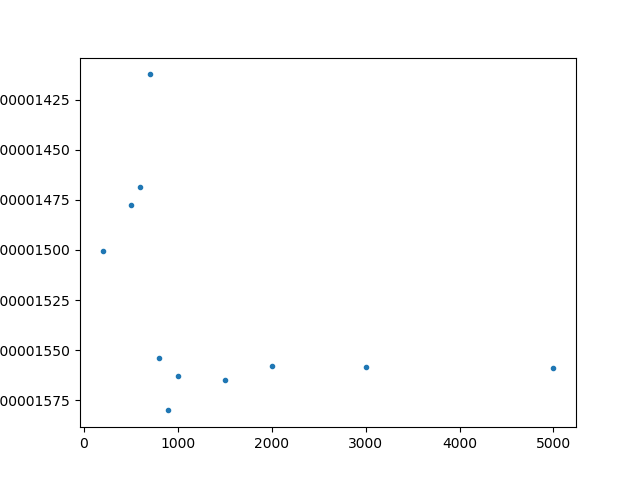

In [8]:
fig, ax = plt.subplots()
ax.plot(Ns, alphas, '.')

<IPython.core.display.Javascript object>


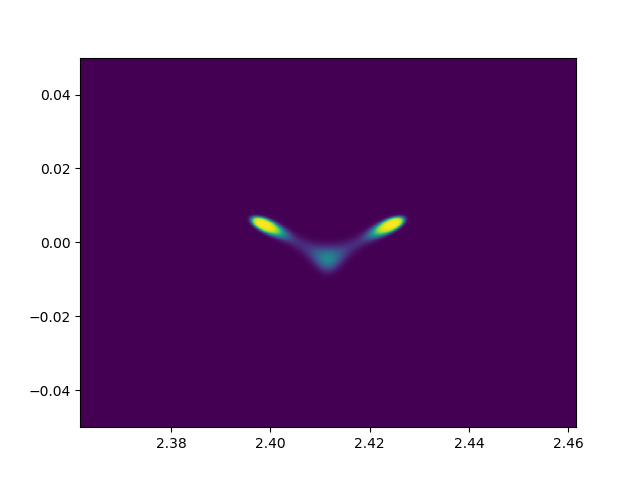

In [16]:
fig, ax = plt.subplots()
ax.pcolormesh(fb.kxa, fb.kya, feq_func(bs.splE[2](fb.kxa, fb.kya), EF, T))

In [17]:
fb.__dict__

{'bs': <blg_strain.bands.BandStructure at 0x2655b66cdc8>,
 'EF': 0.004,
 'T': 4.2,
 'n1': 123548409981233.39,
 'n2': 436371425778213.1,
 'n': 1119839671518893.0,
 'D': 26027027.489771917,
 'kxa': array([2.36160065, 2.36170075, 2.36180085, 2.36190095, 2.36200105,
        2.36210115, 2.36220125, 2.36230135, 2.36240145, 2.36250155,
        2.36260165, 2.36270175, 2.36280185, 2.36290195, 2.36300205,
        2.36310215, 2.36320225, 2.36330235, 2.36340245, 2.36350255,
        2.36360265, 2.36370275, 2.36380285, 2.36390295, 2.36400305,
        2.36410315, 2.36420325, 2.36430335, 2.36440345, 2.36450355,
        2.36460365, 2.36470375, 2.36480385, 2.36490395, 2.36500405,
        2.36510415, 2.36520425, 2.36530435, 2.36540445, 2.36550455,
        2.36560465, 2.36570475, 2.36580486, 2.36590496, 2.36600506,
        2.36610516, 2.36620526, 2.36630536, 2.36640546, 2.36650556,
        2.36660566, 2.36670576, 2.36680586, 2.36690596, 2.36700606,
        2.36710616, 2.36720626, 2.36730636, 2.36740646, 2

In [18]:
fb.kxa.nbytes

8000

# Clean save/load trial

In [11]:
import numpy as np
import glob, os
import matplotlib.pyplot as plt

from blg_strain.lattice import StrainedLattice
from blg_strain.bands import BandStructure, FilledBands
from blg_strain.utils.utils import print_time
from blg_strain.utils.saver import Saver
from blg_strain.utils.utils import Spline
from blg_strain.microscopic import feq_func

from skimage.measure import find_contours
from blg_strain.utils.const import a0, hbar, q

from scipy.interpolate import interp1d

In [12]:
%matplotlib notebook

## Calculate band structure

In [13]:
sl = StrainedLattice(eps=0.01, theta=0)
sl.calculate()

In [14]:
bs = BandStructure(sl, Delta=5e-3)
bs.calculate()

In [15]:
EF=0.004
T = 4.2

In [16]:
%%time
fb = FilledBands(bs, EF=EF, T=T)
fb.calculate(1000, 1000) # what takes so long?

Wall time: 661 ms


In [17]:
sl.save('test3')

In [18]:
bs.save()

In [19]:
fb.save()

In [20]:
path = r"C:\Users\Brian\Documents\GitHub\blg_strain\notebooks\test3\StrainedLattice_eps0.010_theta0.000\BandStructure_Nkx200_Nky200_Delta5.000\FilledBands_EF4.000_T4.2.h5"
fb2 = fb.load(path)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.bytes_'>


In [21]:
fb2.__dict__

{'bs': <blg_strain.utils.saver.Saver at 0x256ae39f088>,
 'EF': 0.004,
 'T': 4.2,
 'D': 26027027.489771917,
 'Nkx_new': 1000,
 'Nky_new': 1000,
 'alpha': array([-1.56307359e-06, -5.01599411e-11]),
 'filename': 'test3\\StrainedLattice_eps0.010_theta0.000\\BandStructure_Nkx200_Nky200_Delta5.000\\FilledBands_EF4.000_T4.2.h5',
 'kxa': array([2.36160065, 2.36170075, 2.36180085, 2.36190095, 2.36200105,
        2.36210115, 2.36220125, 2.36230135, 2.36240145, 2.36250155,
        2.36260165, 2.36270175, 2.36280185, 2.36290195, 2.36300205,
        2.36310215, 2.36320225, 2.36330235, 2.36340245, 2.36350255,
        2.36360265, 2.36370275, 2.36380285, 2.36390295, 2.36400305,
        2.36410315, 2.36420325, 2.36430335, 2.36440345, 2.36450355,
        2.36460365, 2.36470375, 2.36480385, 2.36490395, 2.36500405,
        2.36510415, 2.36520425, 2.36530435, 2.36540445, 2.36550455,
        2.36560465, 2.36570475, 2.36580486, 2.36590496, 2.36600506,
        2.36610516, 2.36620526, 2.36630536, 2.36640546, 2

In [22]:
path = r"C:\Users\Brian\Documents\GitHub\blg_strain\notebooks\test3\StrainedLattice_eps0.010_theta0.000\BandStructure_Nkx200_Nky200_Delta5.000.h5"
bs2 = bs.load(path)

<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.bytes_'>
<class 'numpy.float64'>


In [23]:
bs2.__dict__

{'sl': <blg_strain.utils.saver.Saver at 0x256ae39f048>,
 'window': 0.1,
 'Delta': 0.005,
 'E': array([[[-0.56356571, -0.5622163 , -0.560877  , ..., -0.56087696,
          -0.56221626, -0.56356567],
         [-0.56196874, -0.56061065, -0.55926268, ..., -0.55926265,
          -0.56061062, -0.56196871],
         [-0.56038541, -0.55901859, -0.55766191, ..., -0.55766188,
          -0.55901856, -0.56038537],
         ...,
         [-0.58672533, -0.58480378, -0.58289163, ..., -0.58289157,
          -0.58480372, -0.58672528],
         [-0.58821888, -0.58630105, -0.58439265, ..., -0.58439259,
          -0.586301  , -0.58821883],
         [-0.5897193 , -0.5878052 , -0.58590055, ..., -0.5859005 ,
          -0.58780515, -0.58971925]],
 
        [[-0.20006023, -0.19839779, -0.19673974, ..., -0.19673969,
          -0.19839774, -0.20006018],
         [-0.19889228, -0.19722865, -0.19556937, ..., -0.19556933,
          -0.1972286 , -0.19889223],
         [-0.19772893, -0.19606418, -0.19440376, ..., -0.

In [25]:
sl = StrainedLattice.load(r"C:\Users\Brian\Documents\GitHub\blg_strain\notebooks\test3\StrainedLattice_eps0.010_theta0.000.h5")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>


In [26]:
sl.__dict__

{'eps': 0.01, 'theta': 0, 'strain': array([[ 0.01   ,  0.     ],
        [ 0.     , -0.00165]]), 'K': array([ 2.41160065e+00, -6.96373664e-09]), 'K_bz': array([2.40850687, 0.        ]), 'Kp': array([-2.41160065e+00, -6.96373664e-09]), 'Kp_bz': array([-2.40850687,  0.        ]), 'bz': array([[ 2.40850687,  0.        ],
        [ 1.18317504, -2.09785657],
        [-1.18317504, -2.09785657],
        [-2.40850687,  0.        ],
        [-1.18317504,  2.09785657],
        [ 1.18317504,  2.09785657]]), 'deltans': array([[ 1.74937132,  0.        ],
        [-1.74937132,  0.        ],
        [ 0.87468566,  1.497525  ],
        [ 0.87468566, -1.497525  ],
        [-0.87468566,  1.497525  ],
        [-0.87468566, -1.497525  ]]), 'deltas': array([[ 0.        ,  0.99835   ],
        [ 0.87468566, -0.499175  ],
        [-0.87468566, -0.499175  ]]), 'dimer': 0.022, 'filename': 'test3\\StrainedLattice_eps0.010_theta0.000.h5', 'gamma0s': array([3.17568078, 3.09340252, 3.09340252]), 'gamma3s': array([

# Playing with splines

In [161]:
from scipy.interpolate import bisplev
from scipy.interpolate import BivariateSpline

In [130]:
spl1 = bs.splE[2]
spl2 = bs.splE[2]

In [158]:
def sum_splines(spl1, spl2):
    tx1, ty1, c1, kx1, ky1 = *spl1.tck, *spl1.degrees
    tx2, ty2, c2, kx2, ky2 = *spl2.tck, *spl2.degrees
    
    assert (tx1 == tx2).all()
    assert (ty1 == ty2).all()
    assert kx1 == kx2
    assert ky1 == ky2
    
    c = c1 + c2 
    
    spl = BivariateSpline()
    spl.tck = tx1, ty1, c
    spl.degrees = kx1, ky1
    return spl
    

In [159]:
spl = sum_splines(spl1, spl2)

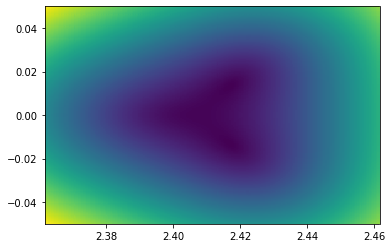

In [160]:
fig, ax = plt.subplots()
ax.pcolormesh(bs.Kxa, bs.Kya, spl(bs.kxa, bs.kya))#bisplev(bs.kxa, bs.kya, spl.tck + spl.degrees))

In [48]:
spl.degrees

(3, 3)

In [47]:
len(*(spl.tck, spl.degrees))

TypeError: len() takes exactly one argument (2 given)